# About this notebook

This notebook explores methods of integrating fire occurrence predictions with economic data in order to estimate fire risk.
The economic data available to us are the value of structures, vehicles, and structure contents for San Diego county in the years 2011 and 2019. This notebook looks at fire data for the year 2018, but uses economic data for the year 2019. This is because our fire perimeter dataset does not include data for the year 2019. The working assumption is that the economic values for 2019 are a good approximation for the year 2018 as well.

## Loading the fire predictions

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style('darkgrid')

In [2]:
%%time
import pandas as pd
import pyarrow.parquet as pq
import s3fs
import boto3

YEAR = 2018
prediction_url = 'wildfire_capstone/logistic_regression_predictions/{}/predictions.parquet.gz/'.format(YEAR)
s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')
s3_keys = [item.key
           for item in s3_resource.Bucket('dse-cohort5-group5').objects.filter(Prefix=prediction_url)
           if item.key.endswith('.parquet')]
display(s3_keys[:3])
s3 = s3fs.S3FileSystem()
s3_url = 'dse-cohort5-group5/{}'
dfs = [pq.ParquetDataset(s3_url.format(key), filesystem=s3).read_pandas().to_pandas() for key in s3_keys]

['wildfire_capstone/logistic_regression_predictions/2018/predictions.parquet.gz/part-00000-cc6dcbda-ffff-4adf-818f-b30d4cc7546a-c000.snappy.parquet',
 'wildfire_capstone/logistic_regression_predictions/2018/predictions.parquet.gz/part-00037-cc6dcbda-ffff-4adf-818f-b30d4cc7546a-c000.snappy.parquet',
 'wildfire_capstone/logistic_regression_predictions/2018/predictions.parquet.gz/part-00038-cc6dcbda-ffff-4adf-818f-b30d4cc7546a-c000.snappy.parquet']

Wall time: 33.8 s


In [3]:
num_rows = sum(len(df) for df in dfs)
num_rows

324850

In [4]:
dfs[0].head()

,date,latitude,longitude,fire_occurred,acres_burned,year,month,day,prediction


In [5]:
%%time
for df in dfs:
    df.date = pd.to_datetime(df.date)
    df.prediction = df.prediction.astype('int')
    df.set_index(['date', 'latitude', 'longitude'], inplace=True)
dfs[0].head()

Wall time: 776 ms


,,,fire_occurred,acres_burned,year,month,day,prediction
date,latitude,longitude,,,,,,


In [6]:
complete_df = pd.concat(dfs)
print(complete_df.shape)
complete_df.head()

(324850, 6)


,,,fire_occurred,acres_burned,year,month,day,prediction
date,latitude,longitude,,,,,,
2018-06-07,32.650000,-116.475000,1,248.380684,2018,06,07,0
2018-07-28,33.066667,-116.933333,1,364.093872,2018,07,28,1
2018-06-07,32.608333,-116.475000,1,248.380684,2018,06,07,0
2018-07-29,33.400000,-117.266667,1,234.830552,2018,07,29,1
2018-07-08,32.816667,-116.766667,1,509.281330,2018,07,08,1


In [7]:
np.sum(complete_df.fire_occurred)

12

In [8]:
np.sum(complete_df.prediction)

39541

In [9]:
yearly_totals_df = complete_df.groupby(by=['latitude', 'longitude']).agg(
    total_actual_fires=pd.NamedAgg(column='fire_occurred', aggfunc='sum'),
    total_predicted_fires=pd.NamedAgg(column='prediction', aggfunc='sum'),
)
yearly_totals_df.head()

total_actual_fires  total_predicted_fires
latitude  longitude                                             
32.483333 -117.141667                   0                     89
          -117.100000                   0                    113
          -117.058333                   0                    151
          -117.016667                   0                    129
          -116.975000                   0                     89

In [10]:
yearly_totals_df.total_actual_fires.value_counts()

0    881
1      7
3      1
2      1
Name: total_actual_fires, dtype: int64

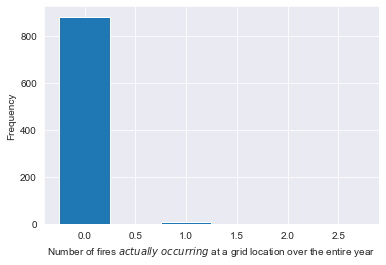

In [11]:
ax = yearly_totals_df.total_actual_fires.hist(bins=6, align='left')
ax.set_ylabel("Frequency")
ax.set_xlabel("Number of fires $\mathit{actually\ occurring}$ at a grid location over the entire year");

In [12]:
yearly_totals_df.total_predicted_fires.value_counts()

0      87
8      30
7      18
34     16
45     16
       ..
129     1
137     1
116     1
119     1
151     1
Name: total_predicted_fires, Length: 124, dtype: int64

In [13]:
np.max(yearly_totals_df.total_predicted_fires.value_counts().index)

151

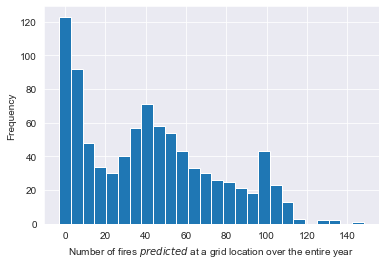

In [14]:
ax = yearly_totals_df.total_predicted_fires.hist(bins=268//10, align='left')
ax.set_ylabel("Frequency")
ax.set_xlabel("Number of fires $\mathit{predicted}$ at a grid location over the entire year");

In [15]:
yearly_totals_df['%_days_predicted_fires'] =yearly_totals_df.total_predicted_fires / 365

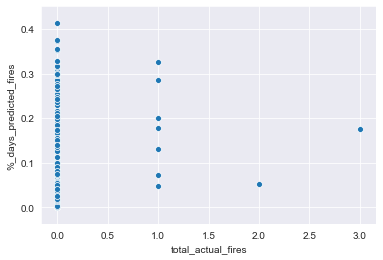

In [16]:
sns.scatterplot(data=yearly_totals_df, x='total_actual_fires', y='%_days_predicted_fires');

## Some observations

The total number of actual fires recorded in 2018 is very small, and there is essentially no correlation between the number of predicted fires and the actual number of fires in the dataset.

# Economic data

Let's explore the economic data a bit to determine the most valuable grid locations.

In [17]:
econ_df = pd.read_csv('grid_econ_2.csv', index_col=0)
print(econ_df.shape)
econ_df.head()

(503, 9)


,longitude,latitude,VAL_STRUCT,VAL_CONT,VAL_VEHIC,COM,IND,PUB,RES
0,-117.600000,33.358333,4.365877e+08,2.785600e+08,47646000.0,10.0,2.0,2.0,631.0
1,-117.600000,33.400000,3.686120e+07,2.703600e+07,2376000.0,2.0,NaN,NaN,45.0
2,-117.600000,33.441667,9.562323e+06,5.567052e+06,1125000.0,NaN,NaN,NaN,12.0
3,-117.558333,33.358333,4.168374e+07,3.097847e+07,2655000.0,2.0,NaN,NaN,40.0
4,-117.558333,33.400000,3.831454e+07,2.097003e+07,3177000.0,NaN,NaN,NaN,36.0


In [18]:
econ_df['total_value'] = np.sum(econ_df[['VAL_STRUCT', 'VAL_CONT', 'VAL_VEHIC']], axis=1)
econ_df.head()

,longitude,latitude,VAL_STRUCT,VAL_CONT,VAL_VEHIC,COM,IND,PUB,RES,total_value
0,-117.600000,33.358333,4.365877e+08,2.785600e+08,47646000.0,10.0,2.0,2.0,631.0,7.627936e+08
1,-117.600000,33.400000,3.686120e+07,2.703600e+07,2376000.0,2.0,NaN,NaN,45.0,6.627320e+07
2,-117.600000,33.441667,9.562323e+06,5.567052e+06,1125000.0,NaN,NaN,NaN,12.0,1.625438e+07
3,-117.558333,33.358333,4.168374e+07,3.097847e+07,2655000.0,2.0,NaN,NaN,40.0,7.531721e+07
4,-117.558333,33.400000,3.831454e+07,2.097003e+07,3177000.0,NaN,NaN,NaN,36.0,6.246157e+07


(251, 10)
Pearson correlation coefficient: 0.03343366773942585


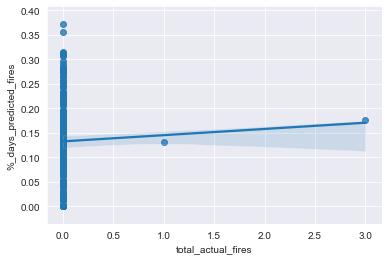

In [20]:
mask = (econ_df.total_value > econ_df.total_value.quantile(0.5))
most_valuable_locations = econ_df[mask]
print(most_valuable_locations.shape)
most_valuable_lons = most_valuable_locations.longitude
most_valuable_lats = most_valuable_locations.latitude
mask = (yearly_totals_df.reset_index().latitude.isin(most_valuable_lats) &
       yearly_totals_df.reset_index().longitude.isin(most_valuable_lons))
pearson = yearly_totals_df.reset_index().loc[mask, ['total_actual_fires', '%_days_predicted_fires']].corr().values[0][1]
print("Pearson correlation coefficient:", pearson)
sns.regplot(data=yearly_totals_df.reset_index()[mask], x='total_actual_fires', y='%_days_predicted_fires');

## Conclusions

Even if we look at the most valuable locations, there's no real correlation between predicted fires and actual fires.
One must conclude that this model isn't sufficiently precise to be useful.